# Etude Snorkel / Extration de partenariats d'entreprises
Pour ce projet, nous allons essayer d'extraire des relations de partenariats économiques entre des entreprises depuis des articles. <br/>
Le but étant de comprendre l'utilisation de snorkel.

Nous allons découper notre traitement dans 3 notebooks (chacun correspondant à une étape du pipeline `Snorkel` :
1. Preprocessing
2. Training
3. Evaluation

## Partie II: Génération et modélisation de "_noisy_" labels contenant du bruit

Dans ce notebook, nous allons écrire nos **fonctions de labelisation** pour étiquetter nos données.
Comme ces `Labeling functions` ne seront pas parfaites, nous allons modéliser leur précision avec un modèle _generative_ que `Snorkel` nous permettra d'appliquer.

Nous les utiliserons pour produire un ensemble de label pour nos données d'entrainement. Ces données bien que contenant du bruit, pourront ensuite être appliquer à un modèle de classification.

***

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import re

import warnings
warnings.filterwarnings("ignore")

import numpy as np
from snorkel import SnorkelSession
from snorkel.models import candidate_subclass
from snorkel.annotations import load_gold_labels
from snorkel.viewer import SentenceNgramViewer
from snorkel.lf_helpers import test_LF
from snorkel.annotations import load_gold_labels
from snorkel.annotations import LabelAnnotator
from snorkel.learning import GenerativeModel
from snorkel.annotations import save_marginals

from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,get_text_splits,
    contains_token, rule_text_btw, rule_text_in_span
)

from lib.scoring import *
from lib.lf_factories import *

session = SnorkelSession()

# I. Préparation des données

## 1. Notre schéma

On initialise de nouveau notre relation de partenariat entre 2 entreprises

In [2]:
Partner = candidate_subclass('Partner', ['company1', 'company2'])

## 2. Chargement de notre jeu de données de _developpement_ et _test_

Nous chargeons les données qui ont été labelisées manuellement et qui font parties de notre jeu de développement (split = 1)

In [3]:
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)

In [4]:
dev_cands   = session.query(Partner).filter(Partner.split == 1).all()
test_cands   = session.query(Partner).filter(Partner.split == 2).all()

## 3. Data exploration

Analysons nos données pour nous aider à créer les fonctions de labeling.

In [5]:
# load our list of training & development candidates
train_cands = session.query(Partner).filter(Partner.split == 0).all()
SentenceNgramViewer(train_cands, session, n_per_page=1)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[178, 179, 180, 181, 182, 183, 859, 860, 861, 862, 863, 959, 960, 961, 962, 1054, 1…

# II. Ecriture des fonctions de labelisation (`Labeling Function`)

`get_left_tokens(c, window=3, attrib='words', n_max=1, case_sensitive=False)
get_right_tokens(c, window=3, attrib='words', n_max=1, case_sensitive=False)
get_between_tokens(c, attrib='words', n_max=1, case_sensitive=False)
get_text_between(c)
get_tagged_text(c)
get_text_split(c)
contains_token`



### Métriques de nos Labeling Function

####  Coverage
C'est le nombre de candidats labelisés par notre LF sur un jeu de données (entrainement).

####  Precision / Recall / F1
Métriques standard pour les classification : précision, rappel, F1-score

In [6]:
# List to parenthetical
def ltp(x):
    return '(' + '|'.join(x) + ')'

## 1. Concurrences

In [7]:
competitors = {'competitor', 'competitors', 'competitive', 'competitives','competition', 'competitions' }
def LF_competitors(c):
    if len(competitors.intersection(get_right_tokens(c[1], window=10))) > 0 :
        return -1
    elif len(competitors.intersection(get_left_tokens(c[0], window=10))) > 0 :
        return -1
    else :
        return 0

labeled = coverage(session, LF_competitors, split=2)
SentenceNgramViewer(labeled, session, n_per_page=1)
tp, fp, tn, fn = error_analysis(session, LF_competitors, split=1, gold=L_gold_dev)
SentenceNgramViewer(fn, session, n_per_page=1)

Coverage: 2.63% (8/304)


<IPython.core.display.Javascript object>

LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 0.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 0 | FN: 0



<IPython.core.display.Javascript object>

SentenceNgramViewer(html='<head>\n<style>\nspan.candidate {\n    background-color: rgba(255,255,0,0.3);\n}\n\n…

In [8]:
against = ['alternative(s)?', 'vs', 'rival(s)?', 'versus', 'surpass(es|ed)?' , 'competitor(s)?', 'leaders ']
def LF_against(c):
    return -1 if re.search(r'{{A}}.{0,50} ' + ltp(against) + '.{0,50}{{B}}',get_tagged_text(c) , re.I) else 0

labeled = coverage(session, LF_against, split=0)
tp, fp, tn, fn = error_analysis(session, LF_against, split=1, gold=L_gold_dev)
SentenceNgramViewer(fn, session, n_per_page=1)

Coverage: 0.65% (16/2464)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 3 | FN: 0



<IPython.core.display.Javascript object>

SentenceNgramViewer(html='<head>\n<style>\nspan.candidate {\n    background-color: rgba(255,255,0,0.3);\n}\n\n…

In [9]:
players = {'players', 'vendors',  'major', 'main','providers', 'provide','provides','comparison', 'compare', 'compares'}
def LF_players(c) :
    if len(players.intersection(get_left_tokens(c[0], window=30))) > 0 :
        return -1 
    elif len(players.intersection(get_right_tokens(c[1], window=30))) > 0 :
        return -1
    else :
        return 0

labeled = coverage(session, LF_players, split=0)
#SentenceNgramViewer(labeled, session, n_per_page=1)
tp, fp, tn, fn = error_analysis(session, LF_players, split=1, gold=L_gold_dev)

Coverage: 25.04% (617/2464)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 8 | FN: 1



## 2. Acquisitions

In [10]:
acquisitions = ['acquir(e|ed|es|ing){1}', 'acquisition','purchase(s|d)?','buy(ing)?', 'bougth', 'parent'] 

def LG_acquisitions_between(c) :
    return -1 if re.search(r'{{A}}.{0,100} ' + ltp(acquisitions) + '.{0,100}{{B}}', get_tagged_text(c), re.I) else 0
     
labeled = coverage(session, LG_acquisitions_between, split=0)
#SentenceNgramViewer(labeled, session, n_per_page=1)
tp, fp, tn, fn = error_analysis(session, LG_acquisitions_between, split=1, gold=L_gold_dev)

Coverage: 1.50% (37/2464)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 0.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 0 | FN: 0



## 3. Alias

In [11]:
def LG_sameNames(c) :
    c1_name = c.company1.get_span()
    c2_name = c.company2.get_span()
    if c1_name == c2_name:
        return -1
    return 0

labeled = coverage(session, LG_sameNames, split=0)
tp, fp, tn, fn = error_analysis(session, LG_sameNames, split=1, gold=L_gold_dev)

Coverage: 13.76% (339/2464)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 19 | FN: 0



In [12]:
def LG_sigle(c):
    return -1 if re.search(r'{{A}}.{0,5}\({{B}}\)', get_tagged_text(c), re.I) else 0

labeled = coverage(session, LG_sigle, split=0)
#SentenceNgramViewer(labeled, session, n_per_page=1)
tp, fp, tn, fn = error_analysis(session, LG_sigle, split=1, gold=L_gold_dev)

Coverage: 0.41% (10/2464)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 0.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 0 | FN: 0



## 4. Partenariat

In [13]:
def LF_with_relations(c):
    return 1 if re.search(r'{{A}}.+with.{0,40}{{B}}',get_tagged_text(c) , re.I) else 0
    

def LF_with_relations_and_not_same(c) :
    return 1 if LF_with_relations(c) == 1 and LG_sameNames(c) != -1  else 0

labeled = coverage(session, LF_with_relations_and_not_same, split=0)
SentenceNgramViewer(labeled, session, n_per_page=1)
tp, fp, tn, fn = error_analysis(session, LF_with_relations_and_not_same, split=1, gold=L_gold_dev)
SentenceNgramViewer(fp, session, n_per_page=1)

Coverage: 9.82% (242/2464)


<IPython.core.display.Javascript object>

LF Score
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            1.0
Recall               1.0
F1                   1.0
----------------------------------------
TP: 9 | FP: 0 | TN: 0 | FN: 0



<IPython.core.display.Javascript object>

SentenceNgramViewer(html='<head>\n<style>\nspan.candidate {\n    background-color: rgba(255,255,0,0.3);\n}\n\n…

In [14]:
cooperations = ['partner(ed|s|ing)?', 'partnership(s)?','collaborat(e|es|ed|ion|ing){1}',
                'cooperat(e|es|ed|ion|ing){1}', 'associat(e|es|ed|ing|ion){1}',  'relationship(s)?',
                'work(s,|ed|ing)?'] 


def LF_cooperations_btw(c):
    return 1 if re.search(r'{{A}}.{0,100} ' + ltp(cooperations) + '.{0,100}{{B}}', get_tagged_text(c), re.I) else 0

def LF_cooperations_btw_and_not_same(c) :
    return 1 if LF_cooperations_btw(c) == 1 and LG_sameNames(c) != -1 else 0

labeled = coverage(session, LF_cooperations_btw_and_not_same, split=0)
tp, fp, tn, fn = error_analysis(session, LF_cooperations_btw_and_not_same, split=1, gold=L_gold_dev)

Coverage: 7.35% (181/2464)
LF Score
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            0.833
Recall               1.0
F1                   0.909
----------------------------------------
TP: 5 | FP: 1 | TN: 0 | FN: 0



In [15]:
relations = ['partner', 'collaborat','cooperat', 
             'associat',  'relation', 'join', 'alliance', 'unit', 'synergy', 'between'] 

def LF_relations_in_sentence(c) :
    return 1 if re.search(r''+ ltp(relations), get_tagged_text(c), re.I) else 0


def LF_relations_in_sentence_and_not_same(c) :
    return 1 if LF_relations_in_sentence(c) == 1 and LG_sameNames(c) != -1  else 0


labeled = coverage(session, LF_relations_in_sentence_and_not_same, split=0)
tp, fp, tn, fn = error_analysis(session, LF_relations_in_sentence_and_not_same, split=1, gold=L_gold_dev)
#SentenceNgramViewer(fp, session, n_per_page=1)

Coverage: 38.56% (950/2464)
LF Score
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            0.893
Recall               1.0
F1                   0.943
----------------------------------------
TP: 25 | FP: 3 | TN: 0 | FN: 0



In [16]:
def LF_no_relations(c) :
    return -1 if not re.search(r''+ ltp(relations), get_tagged_text(c), re.I) else 0
labeled = coverage(session, LF_no_relations, split=0)
tp, fp, tn, fn = error_analysis(session, LF_no_relations, split=1, gold=L_gold_dev)

Coverage: 54.02% (1331/2464)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 46 | FN: 18



In [17]:
def LF_alliances(c) :
    alliances = {'alliance', 'alliances', 'jointly', 'join', 'association', 'associations'}
    if len(alliances.intersection(get_left_tokens(c[0], window=50, case_sensitive=False))) > 0 :
        return 1
    elif len(alliances.intersection(get_right_tokens(c[1], window=50, case_sensitive=False))) > 0 :
        return 1
    else :
        return 0

    
def LF_alliances_and_not_same(c) :
    return 1 if LF_alliances(c) == 1 and LG_sameNames(c) != -1 else 0


labeled = coverage(session, LF_alliances_and_not_same, split=0)
SentenceNgramViewer(labeled, session, n_per_page=1)
tp, fp, tn, fn = error_analysis(session, LF_alliances_and_not_same, split=1, gold=L_gold_dev)

Coverage: 9.05% (223/2464)


<IPython.core.display.Javascript object>

LF Score
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            1.0
Recall               1.0
F1                   1.0
----------------------------------------
TP: 3 | FP: 0 | TN: 0 | FN: 0



In [18]:
def LF_announce(c) :
    return 1 if re.search(r'announce', get_tagged_text(c), re.I) else 0

labeled = coverage(session, LF_announce, split=0)
tp, fp, tn, fn = error_analysis(session, LF_announce, split=1, gold=L_gold_dev)

Coverage: 8.97% (221/2464)
LF Score
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            0.714
Recall               1.0
F1                   0.833
----------------------------------------
TP: 5 | FP: 2 | TN: 0 | FN: 0



## 5. Procès

In [19]:
trials = [ 'su(ed|ing){1}', 'lawsuit(s)?', 'claim(s|ed)?', 'legal', 'jury', 'court(s)?',
          'patent(s)', 'violate(s|d)?', 'allege(s|d)?', 'law' ] 

def LF_trial_in_sentence(c) :
    return -1 if re.search(r''+ ltp(trials), get_tagged_text(c), re.I) else 0

labeled = coverage(session, LF_trial_in_sentence, split=0)
tp, fp, tn, fn = error_analysis(session, LF_trial_in_sentence, split=1, gold=L_gold_dev)

Coverage: 1.91% (47/2464)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 9 | FN: 0



## 6. Clients

In [20]:
def LF_clients(c):
    clients = { 'by', 'from', 'include'}
    return -1 if len(clients.intersection(get_left_tokens(c[1], window=3))) > 0 else 0


labeled = coverage(session, LF_clients, split=0)
tp, fp, tn, fn = error_analysis(session, LF_clients, split=1, gold=L_gold_dev)

Coverage: 3.86% (95/2464)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 4 | FN: 1



# III. Application de nos fonctions de labelisation

## 1. Préparation des fonctions

On regroupe toutes les fonctions dans une liste.

In [21]:
LFs = [
    LF_competitors,
    LF_against, 
    LG_acquisitions_between, 
    LG_sigle, 
    LF_with_relations_and_not_same,
    LF_cooperations_btw_and_not_same,
    LF_relations_in_sentence_and_not_same,
    LF_alliances_and_not_same,
    LF_trial_in_sentence,  
    LF_clients, 
    LF_players,
    LF_no_relations,
    LF_announce,
]

Ensuite nous appliquons nos LFs sur nos candidats d'entrainement afin de produire un ensemble de labels. 

In [22]:
labeler = LabelAnnotator(lfs=LFs)

## 2. Génération de la matrice de _labels_

In [23]:
%time L_train = labeler.apply(split=0, lfs=LFs, parallelism=1)
print("Train shape :", L_train.shape)

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 15.2 s, sys: 187 ms, total: 15.4 s
Wall time: 15.7 s
Train shape : (2464, 13)


In [24]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_competitors,0,0.013799,0.013799,0.000406
LF_against,1,0.006494,0.005682,0.001623
LG_acquisitions_between,2,0.015016,0.014205,0.007711
LG_sigle,3,0.004058,0.004058,0.000812
LF_with_relations_and_not_same,4,0.098214,0.098214,0.040990
LF_cooperations_btw_and_not_same,5,0.073458,0.073458,0.017045
LF_relations_in_sentence_and_not_same,6,0.385552,0.257711,0.093750
LF_alliances_and_not_same,7,0.090503,0.090503,0.007305
LF_trial_in_sentence,8,0.019075,0.018669,0.000812
LF_clients,9,0.038555,0.036932,0.014610


# IV. Entrainement du modèle _génératif_

## 1. Entrainement du modèle

In [25]:
gen_model = GenerativeModel()
gen_model.train(L_train, epochs=10, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6)

Inferred cardinality: 2


In [26]:
gen_model.weights.lf_accuracy

array([ 0.38025778,  0.3623278 ,  0.35713202,  0.36296655,  0.40992082,
        0.42303566,  0.63068176,  0.43964607,  0.36498862,  0.37610567,
        0.51280708,  0.79869475,  0.38880804])

## 2. Application du modèle au jeu d'entrainement

On applique alors notre modèle génératif aux candidats d'entrainements pour avoir leur probabilité de partenariat. Ce vecteur de probabilité est appellé _marginals_ :

In [27]:
train_marginals = gen_model.marginals(L_train)

In [28]:
train_marginals

array([ 0.63346239,  0.77926074,  0.63346239, ...,  0.77926074,
        0.77926074,  0.16834678])

## 3. Analyse de la modèlisation

Distrubution des marginals de nos données d'entrainement.

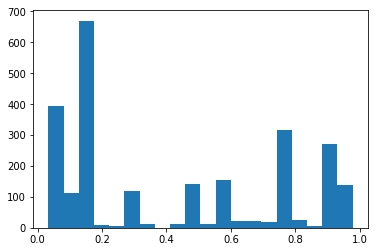

In [29]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

Statistiques du modèle : 

In [30]:
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.683942,0.6850,0.694198,0.471559
1,0.677739,0.6864,0.697173,0.464376
2,0.665483,0.6759,0.680454,0.453504
3,0.671251,0.6762,0.682609,0.457193
4,0.692419,0.6886,0.705933,0.478160
5,0.708249,0.6934,0.721999,0.488061
6,0.766521,0.7097,0.779158,0.535624
7,0.693574,0.6863,0.712701,0.473889
8,0.671027,0.6803,0.684653,0.458163
9,0.689595,0.6833,0.703080,0.469812


## 4. Sauvegarde des marginals

In [31]:
save_marginals(session, L_train, train_marginals)

Saved 2464 marginals


## 5. Analyse de la performance sur les données de développement

In [32]:
%time L_dev = labeler.apply_existing(split=1, lfs=LFs, parallelism=1)
print("Dev shape :",L_dev.shape)

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 2.04 s, sys: 124 ms, total: 2.17 s
Wall time: 2.16 s
Dev shape : (166, 13)


In [33]:
tp, fp, tn, fn  = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.581
Neg. class accuracy: 0.667
Precision            0.379
Recall               0.581
F1                   0.459
----------------------------------------
TP: 25 | FP: 41 | TN: 82 | FN: 18



In [34]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_competitors,0,0.018072,0.018072,0.018072,0,0,0,0,NaN,0.681023
LF_against,1,0.018072,0.018072,0.000000,0,0,0,3,1.000000,0.674756
LG_acquisitions_between,2,0.024096,0.024096,0.012048,0,0,0,0,NaN,0.670194
LG_sigle,3,0.000000,0.000000,0.000000,0,0,0,0,NaN,0.671481
LF_with_relations_and_not_same,4,0.108434,0.108434,0.060241,9,0,0,0,1.000000,0.688180
LF_cooperations_btw_and_not_same,5,0.090361,0.090361,0.012048,5,1,0,0,0.833333,0.700755
LF_relations_in_sentence_and_not_same,6,0.391566,0.204819,0.018072,25,3,0,0,0.892857,0.771497
LF_alliances_and_not_same,7,0.018072,0.018072,0.000000,3,0,0,0,1.000000,0.707544
LF_trial_in_sentence,8,0.072289,0.072289,0.000000,0,0,0,9,1.000000,0.677357
LF_clients,9,0.036145,0.036145,0.000000,0,0,1,4,0.800000,0.671955


## 6. Analyse de la performance sur les données de tests

In [35]:
%time L_test = labeler.apply_existing(split=2, lfs=LFs, parallelism=1)

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 3.05 s, sys: 118 ms, total: 3.17 s
Wall time: 3.19 s


In [36]:
tp, fp, tn, fn  = gen_model.error_analysis(session, L_test, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.615
Neg. class accuracy: 0.676
Precision            0.448
Recall               0.615
F1                   0.519
----------------------------------------
TP: 56 | FP: 69 | TN: 144 | FN: 35

